In [9]:
'''
DeepDA_verify is to verify DA output. 
It read proxy, prior, and posterior from DA outputs files and config file.
It calculates the statistics of the DA results and save the outputs.
By Mingsong Li
Penn State
2/17/2020
'''
from DeepDA_lib import modules_nc
from DeepDA_lib import DeepDA_psm

import h5py
#import time
import yaml
import numpy as np
import pandas
#import os
from netCDF4 import Dataset
from sys import platform as sys_pf
import matplotlib.pyplot as plt
if sys_pf == 'darwin':
    import matplotlib
    matplotlib.use("TkAgg")
    import matplotlib.pyplot as plt
%matplotlib inline

try:
    import bayspline
except ImportError as e1:
    print('Warning:', e1)
try:
    import bayspar
except ImportError as e2:
    print('Warning:', e2)
try:
    import bayfox
except ImportError as e3:
    print('Warning:', e3)
try:
    import baymag
except ImportError as e4:
    print('Warning:', e4)

print('>>  OKAY')

>>  OKAY


In [10]:
config_name = "DeepDA_config.yml"
f = open(config_name, 'r')
yml_dict = yaml.load(f, Loader=yaml.FullLoader)
f.close()

nexp = yml_dict['core']['nexp']
dir_data_save = yml_dict['core']['wrkdir']

nens = yml_dict['core']['nens']
recon_period = yml_dict['core']['recon_period']
recon_timescale = yml_dict['core']['recon_timescale_interval']
recon_period_full = np.arange(recon_period[0],recon_period[1]+1,recon_timescale)
recon_period_len = recon_period_full.shape[0]
save_ens_full = yml_dict['core']['save_ens_full']
proxy_assim2 = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['proxy_assim2']
proxy_psm_type    = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['proxy_psm_type']
proxy_err_eval   = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['proxy_err_eval']

proxy_frac      = yml_dict['proxies']['proxy_frac']
prior_source = yml_dict['prior']['prior_source'] #
dum_lon_offset = yml_dict['prior'][prior_source]['dum_lon_offset'] # longitude offset

data_period_id    = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['data_period_id']
data_period_idstd = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['data_period_idstd']
recon_period = yml_dict['core']['recon_period']
recon_timescale = yml_dict['core']['recon_timescale_interval']
recon_period_full = np.arange(recon_period[0],recon_period[1]+1,recon_timescale)
recon_period_len = recon_period_full.shape[0]

# NetCDF file name
nc_filename = dir_data_save + '/' + yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['dbversion'] + '.' + nexp + '.nc'
print('>>  Read nc file: {}'.format(nc_filename))
# read preprior HDF5 file
dir_proxy_data = dir_data_save +'/'+ yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['dbversion']
proxy_err_eval = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['proxy_err_eval']
hdf5name = dir_proxy_data + '.' + nexp + '_precal_ye.hdf5'

# ========= dataset for plot =========
cGENIEGrid = yml_dict['core']['proj_dir'] + '/data_misc/cGENIEGrid.csv'
cGENIEGrid = pandas.read_csv(cGENIEGrid)

#print(cGENIEGrid)
cGENIEGridB_lat36 = cGENIEGrid['lat']
cGENIEGridB_lon36 = cGENIEGrid['lon']
cGENIEGrid = cGENIEGrid.to_numpy()

print('>>  OKAY.')

>>  Read nc file: /mnt/d/DeepDA/wrk/petmproxy3slices_v0.0.10g.csv.exp_petm9_10g_all_20200220_test1.nc
>>  OKAY.


In [11]:
### Read Proxy ###
proxies=pandas.read_hdf(hdf5name, 'proxies')
prior_variable_dict = pandas.read_hdf(hdf5name, 'prior_variable_dict')

if proxy_frac < 1.0:
    sites_eval = pandas.read_hdf(hdf5name, 'sites_eval')
    sites_withhold_len  = len(sites_eval)
    print('>>  Length of withhold data: {}'.format(sites_withhold_len))
    #print(sites_eval['Proxy'][0])
    #print(sites_eval)
proxy_psm_type_dict_df = pandas.read_hdf(hdf5name, 'proxy_psm_type_dict_df')
proxy_psm_type_dict_list = proxy_psm_type_dict_df[0].values.tolist()
#print(proxy_psm_type_dict_list)

### Read Prior and Posterior ###

field_verify = prior_variable_dict[0][0]
Xb_full_field0 = Dataset(nc_filename).variables[field_verify+'_Xb_full'] # 
Xa_full_field0 = Dataset(nc_filename).variables[field_verify+'_Xa_full'] # 
print('>>  {}_Xb_full shape is {}'.format(field_verify, Xb_full_field0.shape))
print('>>  {}_Xa_full shape is {}'.format(field_verify, Xa_full_field0.shape))
dum_imax = Xb_full_field0.shape[0]
dum_jmax = Xb_full_field0.shape[1]
print('>>  OKAY.')
#print(Xa_full_field0[0,0,:,0,0])

>>  Length of withhold data: 9
>>  ocn_sur_temp_Xb_full shape is (36, 36, 200, 1)
>>  ocn_sur_temp_Xa_full shape is (36, 36, 200, 1, 3)
>>  OKAY.


In [12]:
#print(proxy_assim2)
xb_stat = np.full((sites_withhold_len,2), np.nan)
xa_stat = np.full((sites_withhold_len,recon_period_len*2), np.nan)
ob_stat = np.full((sites_withhold_len,recon_period_len*2), np.nan)

with h5py.File(hdf5name, 'r') as f:
    Xb = f.get('Xb')  # read Xb, background 2d field data
    Xb3d = f.get('Xb3d')  # read Xb, background 3d field data order: lon-lat-depth
    if Xb and Xb3d:
        Xball = np.concatenate((Xb, Xb3d), axis=0)
    elif Xb and Xb3d is None:
        Xball = Xb
    elif Xb is None and Xb3d:
        Xball = Xb3d
    else:
        print('>>  Error! No 3d or 2d variables are listed in {}'.format(config_name))
    Xb0 = np.copy(Xball)  # default Xb
    
print(Xb0.shape)


for j in range(sites_withhold_len):
    data_psm_type = sites_eval['Proxy'][j]
    for key, value in proxy_assim2.items():
        if data_psm_type in value:
            print(proxy_psm_type[key])
            key0 = key
        
    if proxy_psm_type[key0] in ['bayesreg_tex86', 'bayesreg_d18o_pooled']:
        Ye = DeepDA_psm.cal_ye_cgenie(yml_dict,sites_eval,j,Xb0,proxy_assim2,proxy_psm_type,dum_lon_offset,dum_imax,dum_jmax)
        xb_stat[j][0]   = np.mean(Ye)
        xb_stat[j][1] = np.var(Ye)
            
        for reconi in range(recon_period_len):
            
            Xa_reconi = Xa_full_field0[:,:,:,0,reconi].reshape((dum_imax*dum_jmax,nens))
            Ye = DeepDA_psm.cal_ye_cgenie(yml_dict,sites_eval,j,Xa_reconi,proxy_assim2,proxy_psm_type,dum_lon_offset,dum_imax,dum_jmax)
            xa_stat[j][2*reconi]     = np.mean(Ye)
            xa_stat[j][2*reconi + 1] = np.var(Ye)
            
            ob_stat[j][reconi*2]   = sites_eval[data_period_id[reconi]][j]
            if ~np.isnan(sites_eval[data_period_id[reconi]][j]):
                if proxy_psm_type[key0] in ['bayesreg_tex86']:
                    if proxy_err_eval in ['proxy_err_psm']:
                        ob_stat[j][reconi*2+1] = DeepDA_psm.obs_estimate_r_fixed_tex86(31) + sites_eval[data_period_idstd[reconi]][j] ** 2
                    else:
                        ob_stat[j][reconi*2+1] = DeepDA_psm.obs_estimate_r_fixed_tex86(31)
                elif proxy_psm_type[key0] in ['bayesreg_d18o_pooled']:
                    if proxy_err_eval in ['proxy_err_psm']:
                        ob_stat[j][reconi*2+1] = DeepDA_psm.obs_estimate_r_fixed_d18o(15) + sites_eval[data_period_idstd[reconi]][j] ** 2
                    else:
                        ob_stat[j][reconi*2+1] = DeepDA_psm.obs_estimate_r_fixed_d18o(15)
                
    elif proxy_psm_type[key0] in ['bayesreg_mgca_pooled_bcp', 'bayesreg_mgca_pooled_red']:
        geologic_age = yml_dict['core']['geologic_age']
        spp = 'all'
        cleaningr = np.tile(np.array([1]),nens)
        cleaningb = np.tile(np.array([0]),nens)
        if proxy_psm_type[key0] in ['bayesreg_mgca_pooled_red']:
            clearning_one = cleaningr
            proxy_explain = 'reductive'
        elif proxy_psm_type[key0] in ['bayesreg_mgca_pooled_bcp']:
            clearning_one = cleaningb
            proxy_explain = 'barker'
            
        print('    Mg/Ca proxy found. Load salinity, pH and omega')
        with h5py.File(hdf5name, 'r') as f:
            Xb_sal = f.get('Xb_sal')
            Xb_omega = f.get('Xb_omega')
            Xb_ph = f.get('Xb_ph')
            Ye = DeepDA_psm.cal_ye_cgenie_mgca(yml_dict,sites_eval,j,Xb0,proxy_psm_type[key0],dum_lon_offset,dum_imax,dum_jmax,Xb_sal,Xb_ph,Xb_omega,geologic_age)
            xb_stat[j][0]   = np.mean(Ye)
            xb_stat[j][1] = np.var(Ye)
        Xa_sal_full = Dataset(nc_filename).variables['ocn_sur_sal_Xa_full']
        Xa_ph_full  = Dataset(nc_filename).variables['misc_pH_Xa_full']
        Xa_omega_full = Dataset(nc_filename).variables['carb_sur_ohm_cal_Xa_full']
        
        for reconi in range(recon_period_len):
            Xa_reconi = Xa_full_field0[:,:,:,0,reconi].reshape((dum_imax*dum_jmax,nens))
            Xb_sal   =   Xa_sal_full[:,:,:,0,reconi].reshape((dum_imax*dum_jmax,nens))
            Xb_ph    =    Xa_ph_full[:,:,:,0,reconi].reshape((dum_imax*dum_jmax,nens))
            Xb_omega = Xa_omega_full[:,:,:,0,reconi].reshape((dum_imax*dum_jmax,nens))
            
            Ye = DeepDA_psm.cal_ye_cgenie_mgca(yml_dict,sites_eval,j,Xa_reconi,proxy_psm_type[key0],dum_lon_offset,dum_imax,dum_jmax,Xb_sal,Xb_ph,Xb_omega,geologic_age)
            xa_stat[j][2*reconi]     = np.mean(Ye)
            xa_stat[j][2*reconi + 1] = np.var(Ye)
            
            ob_stat[j][reconi*2]   = sites_eval[data_period_id[reconi]][j]
            if ~np.isnan(sites_eval[data_period_id[reconi]][j]):
                ob_err0 = DeepDA_psm.obs_estimate_r_fixed_mgca_pooled((15, 16), clearning_one[0], np.nanmean(Xb_sal), np.nanmean(Xb_ph), np.nanmean(Xb_omega), spp, geologic_age)
                if proxy_err_eval in ['proxy_err_psm']:
                    ob_stat[j][reconi*2+1] = ob_err0 + sites_eval[data_period_idstd[reconi]][j] ** 2
                else:
                    ob_stat[j][reconi*2+1] = ob_err0
    ### TO DO ###

(7776, 200)
bayesreg_d18o_pooled
bayesreg_tex86
bayesreg_d18o_pooled
bayesreg_tex86
bayesreg_d18o_pooled
bayesreg_tex86
bayesreg_d18o_pooled
bayesreg_d18o_pooled
bayesreg_tex86


In [13]:
print('>>  Prior CE: obs vs. xb')
CEb = DeepDA_psm.CE_NS70(ob_stat, np.matlib.repmat(xb_stat,1, reconi+1))
print(CEb)
print('>>  DA CE: obs vs. xa')
CEa = DeepDA_psm.CE_NS70(ob_stat, xa_stat)
print(CEa)
print('')

print('>>  Prior RMSE: obs vs. xb')
rmseb = np.sqrt(np.nanmean((np.matlib.repmat(xb_stat,1, reconi+1) - ob_stat) ** 2, axis=0))
print(rmseb)
print('>>  DA RMSE: obs vs. xa')
rmsea = np.sqrt(np.nanmean((xa_stat - ob_stat) ** 2, axis=0))
print(rmsea)
print('')

print('ob_stat') 
print(ob_stat)
print('xb_stat')
print(xb_stat)
print('xa_stat')
print(xa_stat)

print('')

>>  Prior CE: obs vs. xb
[0.79179258 0.53446812 0.98822735 0.64152146 0.91452819 0.28736327]
>>  DA CE: obs vs. xa
[ 0.9734367  -0.27382426  0.99188754 -1.05627186  0.97642347 -2.46384915]

>>  Prior RMSE: obs vs. xb
[0.87888665 0.09546558 0.2144806  0.08604706 0.48406048 0.10627016]
>>  DA RMSE: obs vs. xa
[0.3139249  0.15791626 0.17804401 0.20608421 0.2542308  0.2342916 ]

ob_stat
[[        nan         nan -3.44519     0.29713171 -3.23291     0.29929252]
 [ 0.53        0.00635615  0.738       0.00645668  0.56        0.00633301]
 [        nan         nan -2.29367     0.29718639 -1.93847     0.30018033]
 [        nan         nan  0.67        0.0065123          nan         nan]
 [-3.47911     0.29715777         nan         nan         nan         nan]
 [ 0.84429     0.00636774         nan         nan         nan         nan]
 [-3.07922769  0.28670757 -4.08692     0.30113615 -3.70692     0.2913654 ]
 [        nan         nan -2.54513     0.2920455          nan         nan]
 [ 0.5373     

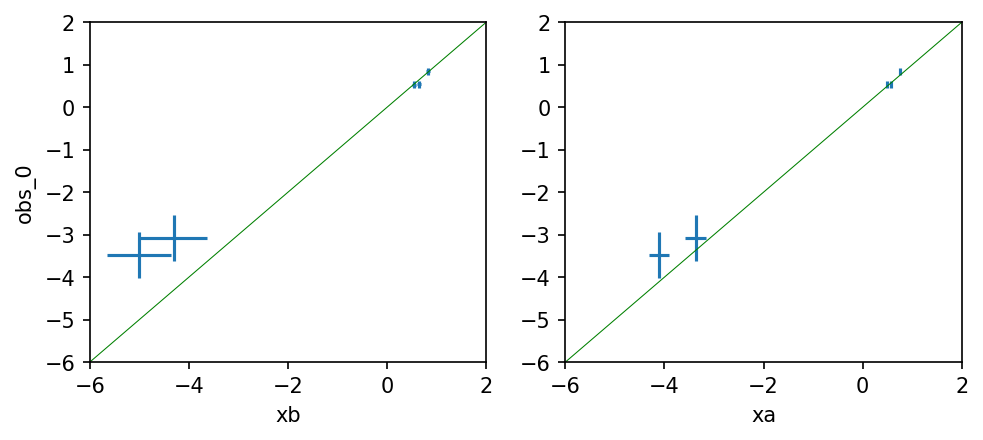

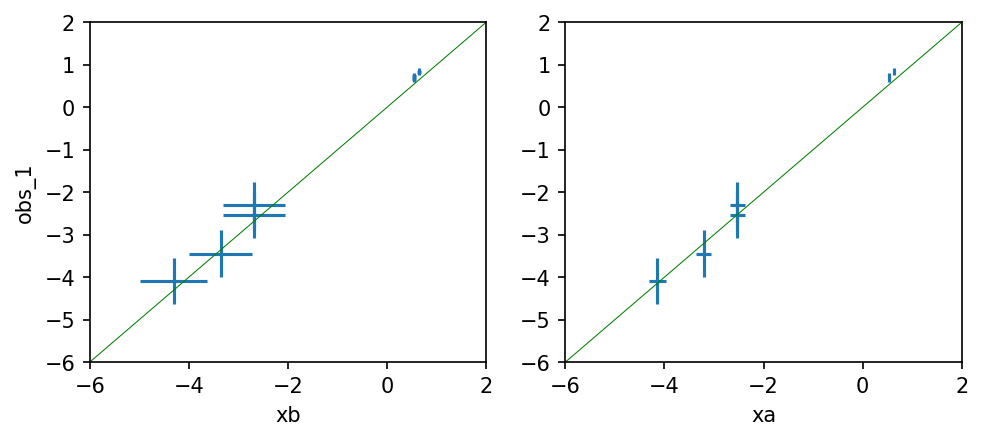

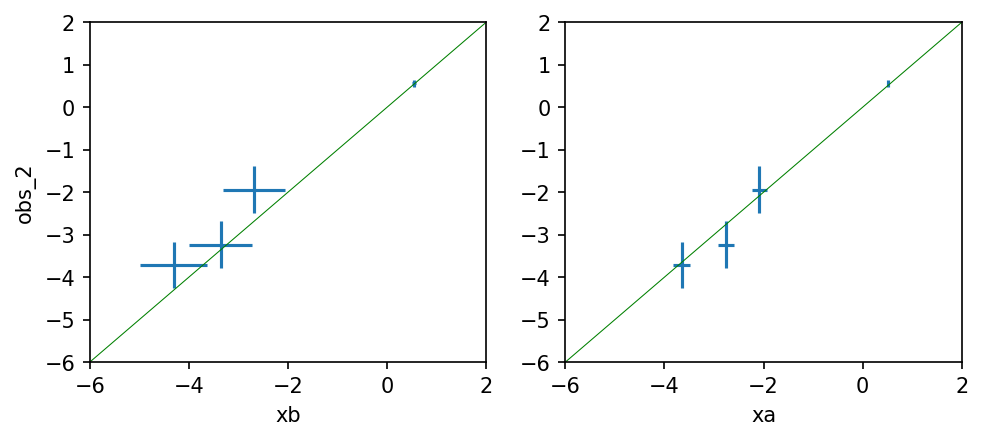

In [14]:
plotn = 1
lim1 = -6
lim2 = 2
if plotn > 0:
    for reconi in range(recon_period_len):
        fig = plt.figure(figsize=(7.5, 3), dpi=150)
        plt.subplot(121)
        plt.plot(np.array([lim1,lim2]), np.array([lim1,lim2]), color='green',linewidth=.5)
        plt.errorbar(xb_stat[:,0], ob_stat[:,2*reconi], xerr = np.sqrt(xb_stat[:,1]), yerr=np.sqrt(ob_stat[:,1+2*reconi]), ls = '')
        plt.xlabel('xb')
        plt.ylabel('obs_' + str(reconi))
        plt.xlim(lim1,lim2)
        plt.ylim(lim1,lim2)
        
        plt.subplot(122)
        plt.plot(np.array([lim1,lim2]), np.array([lim1,lim2]), color='green',linewidth=.5)
        plt.errorbar(xa_stat[:,2*reconi], ob_stat[:,2*reconi], xerr=np.sqrt(xa_stat[:,1+2*reconi]), yerr=np.sqrt(ob_stat[:,1+2*reconi]), ls = '')
        plt.xlabel('xa')
        #plt.ylabel('obs_' + str(reconi))
        plt.xlim(lim1,lim2)
        plt.ylim(lim1,lim2)
    #plt.yscale('log')
    #plt.savefig('VarReduced-comp1.pdf')